In [12]:
import torch
import torchtext
from torchtext import datasets
import torch.nn as nn
import torch.nn.functional as F
import re
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import os
import spacy # use <!pip install spacy> and <!python -m spacy download en> if you dont have spacy
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
#select the path where you want to save model prameters

PATH = '/home/sanala/Juputer try/HSD/model-parameters/bi-lstm-hasoc.pt'


#Select which data you want to work with 
#data path
DataPath= '/home/sanala/Juputer try/HSD'   #change it to your path
#data
train_data='has21_traindata.csv'           #<has20_traindata.csv> or <has21_traindata.csv> or <has19-20-21_conmined_train.csv>
valid_data='has21_devdata.csv'             #<has21_devdata.csv> or <has21_devdata.csv> or <has19-20-21_conmined_valid.csv>
test_data= 'has21_testwithlabels.csv'            #<has21_testdata.csv> or <has21_testdatawithlabels.csv> <has21_testdata.csv>


    
def hasoc_combined_data():
    data1a = pd.read_csv('has19_traindata.csv')
    data2b = pd.read_csv('has19_devdata.csv')
    data1aa = pd.read_csv('has20_traindata.csv')
    data2bb = pd.read_csv('has20_devdata.csv')
    data1aaa = pd.read_csv('has21_traindata.csv')
    data2bbb = pd.read_csv('has21_devdata.csv')
    
    train_data, valid_data = pd.concat([data1a, data1aa, data1aaa]), pd.concat([data2b, data2bb, data2bbb])
    test_data='hasoc21_testwithlabels.csv'
    #if datayear == '2020':
            #print('Using Hasoc combined data for Hasoc 2020 test data... ')
            #testdata = pd.read_csv(args.has20_testdata)
    #else:
            #print('Using Hasoc combined data for Hasoc 2021 test data... ')
    train_data.to_csv('/home/sanala/Juputer try/HSD/has19-20-21_conmined_train.csv')
    valid_data.to_csv('/home/sanala/Juputer try/HSD/has19-20-21_conmined_valid.csv')
    

#set to True if you want to work with hasoc_combined 19_20_21
hasoc_combined=False

if hasoc_combined:
    hasoc_combined_data()
    train_data='has19-20-21_conmined_train.csv'           #<has21_traindata.csv> or <has_combined_traindata.csv>
    valid_data='has19-20-21_conmined_valid.csv'             #<has21_devdata.csv> or <has21_devdata.csv>
    test_data= 'has21_testdatawithlabels.csv'
    

#pre-preocessing 
def text_clean(text):
    text = re.sub(r'[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', text)                  # remove emails                    
    text = re.sub(r'((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', text)# remove IP address
    text = re.sub(r'http\S+', '', text)                                          # remove URLs
    text = re.sub(r'www\S+ ', '', text)                                          # remove URLs
    text = re.sub(r'[^\w\s#@/:%.,_-]', '', text, flags=re.UNICODE)               # remove emojis+
    text = re.sub(r'[#,@,&,<,>,\,/,-]', '', text)
    text = text.replace('[','')
    text = text.replace(']','')
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    text = text.replace(' {2,}', ' ')                                            # remove 2 or more spaces
    text = text.strip()
    text = text.lower()
    text = re.sub(r'\d', '', text)                                              # remove numbers

    return text

# define model

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)
    
#define function to plot training  loss vs validation loss to check  overfitting     
def plotLosses(train_losses,val_losses):
    plt.plot(train_losses,label='Training Loss')  
    plt.plot(val_losses,label='Validation Loss')  
    plt.legend() 
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
#function to return  scors   
def f1_score_func(preds, labels):
    return f1_score(labels, preds, average=None), f1_score(labels, preds, average="weighted"), f1_score(labels, preds, average="micro")

#training function 
def train(model, train_iterator, optimizer, criterion):
    print ('start training' )   
    
    train_epoch_loss = 0
    train_epoch_acc = 0

    model.train()
    
    for batch in train_iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)


        
        loss = criterion(predictions, batch.task_1)
        
        rounded_preds = torch.round(torch.sigmoid(predictions))
        correct = (rounded_preds == batch.task_1).float() 
        
        acc = correct.sum() / len(correct)
        
        loss.backward()
        
        optimizer.step()
        
        train_epoch_loss += loss.item()
        train_epoch_acc += acc.item()
             
    return train_epoch_loss / len(train_iterator), train_epoch_acc / len(train_iterator)

#Evaluation  function
def evaluation(model,valid_iterator):
    print('Thin is the validation result')
    valid_epoch_loss = 0
    valid_epoch_acc = 0
    predictions_tst = []
    true_vals=[]
    model.eval()
    with torch.no_grad():

      for batch in valid_iterator:

          predictions = model(batch.text).squeeze(1)
          for a in predictions:            # pick each element - no list comprehension
            predictions_tst.append(torch.round(torch.sigmoid(a)))
          for a in batch.task_1: 
            true_vals.append(a)

          loss = criterion(predictions, batch.task_1)

          rounded_preds = torch.round(torch.sigmoid(predictions))
          correct = (rounded_preds == batch.task_1).float() 
        
          acc = correct.sum()/len(correct)

          valid_epoch_loss += loss.item()
          valid_epoch_acc += acc.item()

    predictions_tst = torch.stack(predictions_tst)
    true_vals = torch.stack(true_vals)
    #valid_loss = valid_epoch_loss / len(valid_iterator)
    #valid_acc = valid_epoch_acc / len(valid_iterator) 
       
    return valid_epoch_loss / len(valid_iterator), valid_epoch_acc / len(valid_iterator ),predictions_tst,true_vals    
#test function

def test(model, test_iterator,path):
  print ('this the testing result' )   

  epoch_loss = 0
  epoch_acc = 0
  model.load_state_dict(torch.load(path))

  model.eval()
  predictions_tst = []
  true_vals=[]
  IDs=[]

  with torch.no_grad():

      for batch in test_iterator:

          predictions = model(batch.text).squeeze(1)
          for a in predictions:            # pick each element - no list comprehension
            predictions_tst.append(torch.round(torch.sigmoid(a)))
          for a in batch.task_1: 
            true_vals.append(a)
          for a in batch._id: 
            IDs.append(a)#better if it was a dictionary (id:label)
         
          loss = criterion(predictions, batch.task_1)
          rounded_preds = torch.round(torch.sigmoid(predictions))
          correct = (rounded_preds == batch.task_1).float() 
        
          acc = correct.sum()/len(correct)

          epoch_loss += loss.item()
          epoch_acc += acc.item()

  predictions_tst = torch.stack(predictions_tst)
  true_vals = torch.stack(true_vals)
 
  test_loss = epoch_loss / len(test_iterator)
  test_acc = epoch_acc / len(test_iterator)
  return test_loss , test_acc,predictions_tst,true_vals,IDs

#function to test user input
def predict_class(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    preds = model(tensor)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

In [13]:
#start pre-processin
nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])

def tokenizer(s): 
    return [w.text.lower() for w in nlp(text_clean(s))]
TEXT = torchtext.legacy.data.Field(tokenize = tokenizer)

LABEL = torchtext.legacy.data.LabelField(dtype = torch.float)
ID = torchtext.legacy.data.RawField()
datafields = [('_id', ID) ,('text', TEXT),('task_1', LABEL) ,('task_2', None)]

#read data
#change the path 
trn,vld, tst = torchtext.legacy.data.TabularDataset.splits(path =DataPath, 
                                                train = train_data,
                                                validation=valid_data,
                                                test = test_data,    
                                                format = 'csv',
                                                skip_header = True,
                                                fields = datafields)
#check data
#print(f'Number of training examples: {len(trn)}')
#print(f'Number of validation examples: {len(vld)}')
#print(f'Number of testing examples: {len(tst)}')

#vars(trn.examples[0
#vars(tst.examples[50])

TEXT.build_vocab(trn, max_size=25000,
                 vectors="glove.6B.100d",## #pretrained vectors are ['charngram.100d', 'fasttext.en.300d', 'fasttext.simple.300d', 'glove.42B.300d', 'glove.840B.300d', 'glove.twitter.27B.25d', 'glove.twitter.27B.50d', 'glove.twitter.27B.100d', 'glove.twitter.27B.200d', 'glove.6B.50d', 'glove.6B.100d', 'glove.6B.200d', 'glove.6B.300d']
                 unk_init=torch.Tensor.normal_)

LABEL.build_vocab(trn)
#print(LABEL.vocab.stoi)
train_iterator,valid_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits(
                                (trn,vld, tst),
                                batch_size = 50,
                                sort_key=lambda x: len(x.text),
                                sort_within_batch=False,
                                device = device)

In [14]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2,3,4]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
 
#print(pretrained_embeddings.shape)
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM) 

optimizer = optim.Adam(model.parameters())

model=model.to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
#print(model.embedding.weight.data)

start training
Thin is the validation result
| Epoch: 01 | Train Loss: 0.599 | Train Acc: 69.36% | Valid Loss: 0.543 | Valid Acc: 74.75 | F1: [0.81851852 0.57391304], weighted F1: 0.7327477675303762, micro F1: 0.7454545454545455%
              precision    recall  f1-score   support

         0.0       0.76      0.88      0.82       250
         1.0       0.69      0.49      0.57       135

    accuracy                           0.75       385
   macro avg       0.73      0.69      0.70       385
weighted avg       0.74      0.75      0.73       385

Validation loss decreased (inf --> 0.543435).   Saving model ...
start training
Thin is the validation result
| Epoch: 02 | Train Loss: 0.508 | Train Acc: 75.93% | Valid Loss: 0.504 | Valid Acc: 75.89 | F1: [0.83060109 0.57918552], weighted F1: 0.7424423856439285, micro F1: 0.7584415584415585%
              precision    recall  f1-score   support

         0.0       0.76      0.91      0.83       250
         1.0       0.74      0.47      

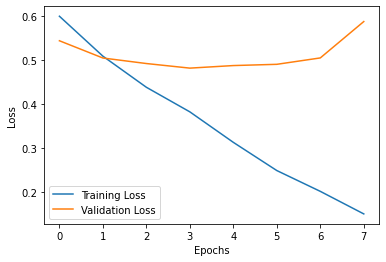

this the testing result
Test Loss: 0.473 | Test Acc: 78.44 F1: [0.84335982 0.655     ], weighted F1: 0.77233890325822, micro F1: 0.784543325526932 % 
              precision    recall  f1-score   support

         0.0       0.77      0.93      0.84       798
         1.0       0.83      0.54      0.66       483

    accuracy                           0.78      1281
   macro avg       0.80      0.74      0.75      1281
weighted avg       0.79      0.78      0.77      1281



In [15]:
num_epochs = 8
valid_loss_min = np.Inf 
val_losses=[]
train_losses=[]
for epoch in range(num_epochs):
     
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc,predictions,true_vals = evaluation(model, valid_iterator)

    val_f1, val_f1_w, val_f1_mic = f1_score_func(predictions.detach().cpu().numpy(), true_vals.detach().cpu().numpy())
    #val_f1, val_f1_w, val_f1_mic = f1_score_func(predictions, true_vals)
    
    val_losses.append(valid_loss)
    train_losses.append(train_loss)
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f} | F1: {val_f1}, weighted F1: {val_f1_w}, micro F1: {val_f1_mic}%')
    print(classification_report(true_vals.detach().cpu().numpy()
, predictions.detach().cpu().numpy()))
    if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,valid_loss))
      valid_loss_min = valid_loss
      torch.save(model.state_dict(), PATH)  
plotLosses(train_losses,val_losses)

test_loss , test_acc,predictions_tst,true_vals,IDs=test(model, test_iterator,PATH)
val_f1, val_f1_w, val_f1_mic = f1_score_func(predictions_tst.detach().cpu().numpy()
, true_vals.detach().cpu().numpy()
)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f} F1: {val_f1}, weighted F1: {val_f1_w}, micro F1: {val_f1_mic} % ')

print(classification_report(true_vals.detach().cpu().numpy()
, predictions_tst.detach().cpu().numpy()))
#These are the list of the _id and needed to combine with true_vals to make the CSV for hasoc submission
#print(IDs)